<a href="https://colab.research.google.com/github/ishaan112233/Artistic_Style_Transfer/blob/master/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import numpy as np
import time
from PIL import Image
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from scipy.optimize import fmin_l_bfgs_b


In [0]:
!wget -c https://dur-cjweb.newscyclecloud.com/storyimage/CJ/20190121/NEWS01/190129977/AR/0/AR-190129977.jpg -O style.jpg

--2019-05-21 08:44:46--  https://dur-cjweb.newscyclecloud.com/storyimage/CJ/20190121/NEWS01/190129977/AR/0/AR-190129977.jpg
Resolving dur-cjweb.newscyclecloud.com (dur-cjweb.newscyclecloud.com)... 52.3.98.54, 34.236.25.26
Connecting to dur-cjweb.newscyclecloud.com (dur-cjweb.newscyclecloud.com)|52.3.98.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 700166 (684K)
Saving to: ‘style.jpg’

style.jpg           100%[===================>] 683.76K  --.-KB/s    in 0.06s   

2019-05-21 08:44:46 (11.1 MB/s) - ‘style.jpg’ saved [700166/700166]



In [0]:
!wget -c https://images.pexels.com/photos/2049487/pexels-photo-2049487.jpeg -O test.jpg

--2019-05-21 08:44:51--  https://images.pexels.com/photos/2049487/pexels-photo-2049487.jpeg
Resolving images.pexels.com (images.pexels.com)... 104.17.208.102, 104.17.209.102, 2606:4700::6811:d066, ...
Connecting to images.pexels.com (images.pexels.com)|104.17.208.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8309501 (7.9M) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]   7.92M  --.-KB/s    in 0.1s    

2019-05-21 08:44:52 (56.4 MB/s) - ‘test.jpg’ saved [8309501/8309501]



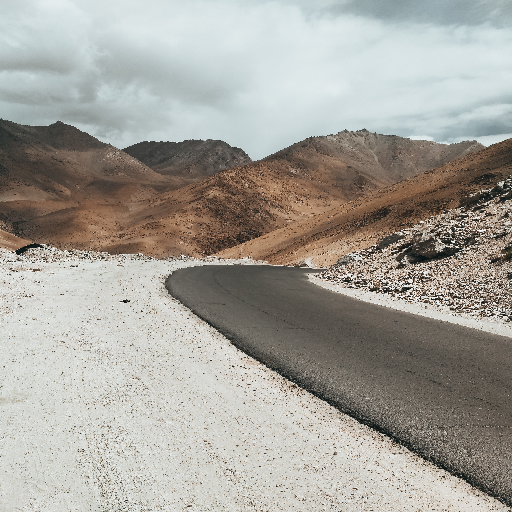

In [0]:
height = 512
width = 512
content_image_path = './test.jpg' 
content_image = Image.open(content_image_path)
content_image = content_image.resize((width , height))
content_image

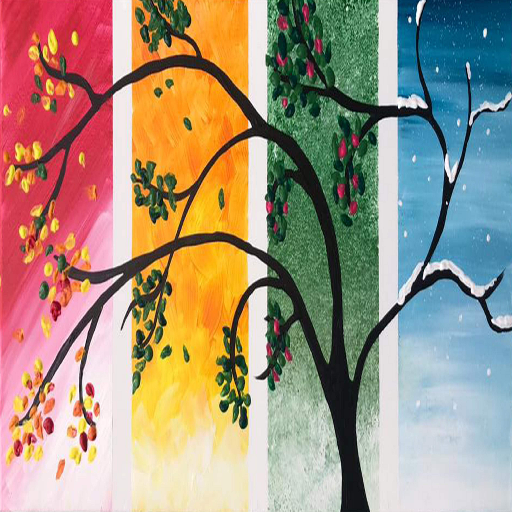

In [0]:
style_image_path = './style.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width , height))
style_image

In [0]:
content_array = np.asarray(content_image , dtype='float32')
content_array = np.expand_dims(content_array , axis = 0)
print(content_array.shape)


style_array = np.asarray(style_image , dtype='float32')
style_array = np.expand_dims(style_array , axis = 0)
print(style_array.shape)
# print(content_array[:,:,:,::-1])

(1, 512, 512, 3)
(1, 512, 512, 3)


In [0]:
content_array[:,:,:,0] -= 103.939
content_array[:,:,:,1] -= 116.779
content_array[:,:,:,2] -= 123.68
#Flip the ordering of the multi-dimensional array from RGB to BGR
content_array = content_array[:,:,:,::-1]

style_array[:,:,:,0] -= 103.939
style_array[:,:,:,1] -= 116.779
style_array[:,:,:,2] -= 123.68
#Flip the ordering of the multi-dimensional array from RGB to BGR
style_array = style_array[:,:,:,::-1]

In [0]:
#Variable for content and style image
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
#Combination image that retains image's content while incorporating style of style image 
combination_image = backend.placeholder((1, height, width, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
#Concatinate all image data to single tensor for feeding to keras VGG16
input_tensor = backend.concatenate([content_image , style_image , combination_image] , axis=0)

In [0]:
#By making include_top: False we do not include any of the fully connected layers
model = VGG16(input_tensor = input_tensor , weights = 'imagenet' ,include_top = False)

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
#Name of layers we will be using
layers = dict([(layer.name , layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

In [0]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [0]:
loss = backend.variable(0.)

In [0]:
#Content loss is Euclidean distance between content and combined image
def content_loss(content , combination):
  return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0,:,:,:]
combination_features = layer_features[2,:,:,:]

loss += content_weight * content_loss(content_image_features , combination_features)


In [0]:
#Gram Matrix (--) => X*X^(T)
def gram_matrix(x):
  features = backend.batch_flatten(backend.permute_dimensions(x , (2,0,1)))
  gram = backend.dot(features , backend.transpose(features))
  return gram

In [0]:
def style_loss(style , combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = height * width
  return backend.sum(backend.square(S-C))/(4. * (channels**2) * (size**2))

feature_layers = ['block1_conv2','block2_conv2','block3_conv3','block4_conv2','block5_conv3']

for layer_name in feature_layers:
  layer_features = layers[layer_name]
  style_features = layer_features[1,:,:,:]
  combination_features = layer_features[2,:,:,:]
  sl = style_loss(style_features , combination_features)
  loss += (style_weight / len(feature_layers)) * sl

In [0]:
#total_variation loss : A regularization term (noise-level of the generated image)

def total_variation_loss(x):
  a = backend.square(x[:,:height-1 , :width-1 , :] - x[:,1:,:width-1,:])
  b = backend.square(x[:,:height-1 , :width-1 , :] - x[:1 , :height-1 , 1: , :])
  return backend.sum(backend.pow(a+b , 1.25))
loss += total_variation_weight * total_variation_loss(combination_image)

In [0]:
#Using Gradients to iteratively improve the minization loss
grads = backend.gradients(loss , combination_image)

In [0]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image] , outputs)


def eval_loss_and_grads(x):
  x = x.reshape((1,height , width , 3))
  outs = f_outputs([x])
  loss_value = outs[0]
  grad_values = outs[1].flatten().astype('float64')
  return loss_value , grad_values

class Evaluator(object):
  
  def __init__(self):
    self.loss_value = None
    self.grad_value = None
    
  def loss(self , x):
    assert self.loss_value is None
    loss_value , grad_values = eval_loss_and_grads(x)
    self.loss_value = loss_value
    self.grad_values = grad_values
    return self.loss_value
  
  def grads(self , x):
    assert self.loss_value is not None
    grad_values = np.copy(self.grad_values)
    self.loss_value = None
    self.grad_values = None
    return grad_values
  
evaluator = Evaluator()

In [0]:
x = np.random.uniform(0,255,(1,height,width,3))-128
itr = 20
for i in range(itr):
  print('Start of Iteration:',i)
  start_time = time.time()
  x , min_val , info = fmin_l_bfgs_b(evaluator.loss , x.flatten() , fprime = evaluator.grads , maxfun = 20)
  print('Current loss value:', min_val)
  end_time = time.time()
  print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of Iteration: 0
Current loss value: 171994400000.0
Iteration 0 completed in 23s
Start of Iteration: 1
Current loss value: 89809330000.0
Iteration 1 completed in 15s
Start of Iteration: 2
Current loss value: 64936650000.0
Iteration 2 completed in 15s
Start of Iteration: 3
Current loss value: 56142873000.0
Iteration 3 completed in 15s
Start of Iteration: 4
Current loss value: 52006175000.0
Iteration 4 completed in 15s
Start of Iteration: 5
Current loss value: 49788700000.0
Iteration 5 completed in 15s
Start of Iteration: 6
Current loss value: 48280390000.0
Iteration 6 completed in 15s
Start of Iteration: 7
Current loss value: 47271653000.0
Iteration 7 completed in 15s
Start of Iteration: 8
Current loss value: 46449455000.0
Iteration 8 completed in 15s
Start of Iteration: 9
Current loss value: 45738430000.0
Iteration 9 completed in 15s
Start of Iteration: 10
Current loss value: 45166680000.0
Iteration 10 completed in 15s
Start of Iteration: 11
Current loss value: 44731036000.0
Itera

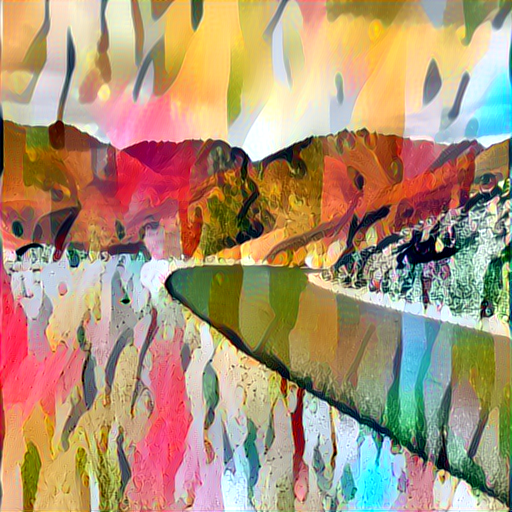

In [0]:
x = x.reshape((height , width , 3))
x = x[:,:,::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x , 0 , 255).astype('uint8')

Image.fromarray(x)

In [0]:
model.save('./model.h5')